# Loading Data

In [1]:
from dataset import LFWDataset

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import transforms

import numpy as np

import os
import time
import random

import matplotlib.pyplot as plt

from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

/opt/anaconda3/envs/mv-tec/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:14: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.5)
  from scipy.sparse import csr_matrix, issparse


In [2]:
#!pip install thop

In [3]:
# 64x64 
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
# cargamos dataset
full_dataset = LFWDataset(
    faces_folder="faces",
    smiling_labels_file="lists/SMILE_list.txt",
    non_smiling_labels_file="lists/NON-SMILE_list.txt",
    transform=transform
)
print("Total imágenes:", len(full_dataset))

# full_dataset[i] = (img_tensor, label_tensor) #tupla
# img_tensor -> shape (3, H, W)
#label_tensor -> shape (1,) o un escalar dentro del tensor


Total imágenes: 1203


# Train

In [4]:

# Semilla 
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Train / Val / Test split (estratificado)
test_ratio = 0.20
val_ratio  = 0.10   # porcentaje del total

n_total = len(full_dataset)

# Extraemos las etiquetas de las imágenes
all_labels  = np.array([full_dataset[i][1].item() for i in range(n_total)])
all_indices = np.arange(n_total)

# Divdidimos las etiquetas en 30% (test + val), y 70% (train)
train_idx, temp_idx = train_test_split(
    all_indices,
    test_size = test_ratio + val_ratio,   # 20% + 10% = 30%
    stratify = all_labels, #estratificamos según si es smile y no
    random_state = 42
)

# Dividimos el 30% 
temp_labels = all_labels[temp_idx]

val_rel = val_ratio / (val_ratio + test_ratio)  # proporción dentro de Temp
# val_rel = 0.10 / 0.30 = 0.3333

val_idx, test_idx = train_test_split(
    temp_idx,
    test_size = 1 - val_rel,      # 0.6666 de Temp va a Test
    stratify = temp_labels,        # estratificamos según las labels en temp
    random_state = 42
)

# pasamos a subsets  
train_dataset = Subset(full_dataset, train_idx)
val_dataset   = Subset(full_dataset, val_idx)
test_dataset  = Subset(full_dataset, test_idx)

print("Train:", len(train_dataset),
      " Val:", len(val_dataset),
      " Test:", len(test_dataset))

# Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)



Device: cpu
Train: 842  Val: 120  Test: 241


In [ ]:
# Funciones para métricas
def count_parameters(model):
    """Parámetros entrenables de un modelo PyTorch."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad) #por si congelado

# revisar si dejamos esto
def count_operations(model, input_size=(1, 3, 64, 64)):
    """FLOPs usando thop. Instala antes: pip install thop"""
    from thop import profile
    model_eval = model.to(device)
    model_eval.eval()
    dummy = torch.randn(*input_size).to(device)
    flops, params = profile(model_eval, inputs=(dummy,), verbose=False)
    return flops

def count_time(model, x, n_runs=100, warmup=10):
    """Tiempo de inferencia (media y std) para modelos PyTorch."""
    import time
    model.eval()
    x = x.to(device)
    times = []

    with torch.no_grad():
        for i in range(warmup):
            i = model(x)
    with torch.no_grad():
        # mediciones
        for j in range(n_runs):
            start = time.time()
            j = model(x)
            end = time.time()
            times.append(end - start)
    times = np.array(times)
    return times.mean(), times.std()

## CNN

In [6]:
# class CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),              # 64 -> 32
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)               # 32 -> 16
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 16 * 16, 64),
            nn.ReLU(),
            nn.Dropout(0.65), # para arreglar overfitting 
            nn.Linear(64, 2)              # 2 clases: 0 no-smile, 1 smile
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

cnn = SimpleCNN().to(device)
criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(cnn.parameters(), lr=1e-3, weight_decay=1e-3) # L2: regularización suave

In [7]:
def train_eval_cnn(model, train_loader, val_loader, test_loader,
                   criterion, optimizer, epochs=10):

    train_acc_history = []
    val_acc_history   = []

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc  = correct / total

        # evaluación en val
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = outputs.max(1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_acc = correct_val / total_val

        # guardamos en las listas 
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        print(f"[CNN] Epoch {epoch+1}/{epochs} - "
              f"Train acc: {train_acc:.3f}  Val acc: {val_acc:.3f}")

    train_time = time.time() - start_time

    # accuracy 
    def accuracy_on_loader(loader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = outputs.max(1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        return correct / total

    final_train_acc = accuracy_on_loader(train_loader)
    final_val_acc   = accuracy_on_loader(val_loader)
    final_test_acc  = accuracy_on_loader(test_loader)

    # --- tiempo de inferencia ---
    sample_batch, _ = next(iter(test_loader))
    mean_t, std_t = count_time(model, sample_batch, n_runs=100)

    metrics = {
        "train_accuracy": final_train_acc,
        "val_accuracy":   final_val_acc,
        "test_accuracy":  final_test_acc,
        "training_time_sec": train_time,
        "inference_time_mean_ms": mean_t * 1000,
        "inference_time_std_ms":  std_t * 1000,
        "num_parameters":  count_parameters(model),
        "flops_per_forward": count_operations(model),

    }
    return metrics, train_acc_history, val_acc_history


In [8]:
cnn_metrics , train_history, val_history= train_eval_cnn(
    cnn,
    train_loader,
    val_loader,
    test_loader,
    criterion_cnn,
    optimizer_cnn,
    epochs=13
)

print("\nMétricas CNN:")
for metric, value in cnn_metrics.items():
    print( metric, ":", value)



[CNN] Epoch 1/13 - Train acc: 0.603  Val acc: 0.792
[CNN] Epoch 2/13 - Train acc: 0.757  Val acc: 0.908
[CNN] Epoch 3/13 - Train acc: 0.847  Val acc: 0.917
[CNN] Epoch 4/13 - Train acc: 0.886  Val acc: 0.958
[CNN] Epoch 5/13 - Train acc: 0.880  Val acc: 0.933
[CNN] Epoch 6/13 - Train acc: 0.901  Val acc: 0.900
[CNN] Epoch 7/13 - Train acc: 0.869  Val acc: 0.950
[CNN] Epoch 8/13 - Train acc: 0.903  Val acc: 0.900
[CNN] Epoch 9/13 - Train acc: 0.913  Val acc: 0.967
[CNN] Epoch 10/13 - Train acc: 0.923  Val acc: 0.967
[CNN] Epoch 11/13 - Train acc: 0.923  Val acc: 0.950
[CNN] Epoch 12/13 - Train acc: 0.920  Val acc: 0.958
[CNN] Epoch 13/13 - Train acc: 0.935  Val acc: 0.958

Métricas CNN:
train_accuracy : 0.9833729216152018
val_accuracy : 0.9583333333333334
test_accuracy : 0.941908713692946
training_time_sec : 10.851721286773682
inference_time_mean_ms : 8.597795963287354
inference_time_std_ms : 1.0397842199866454
num_parameters : 529666
flops_per_forward : 7405696.0


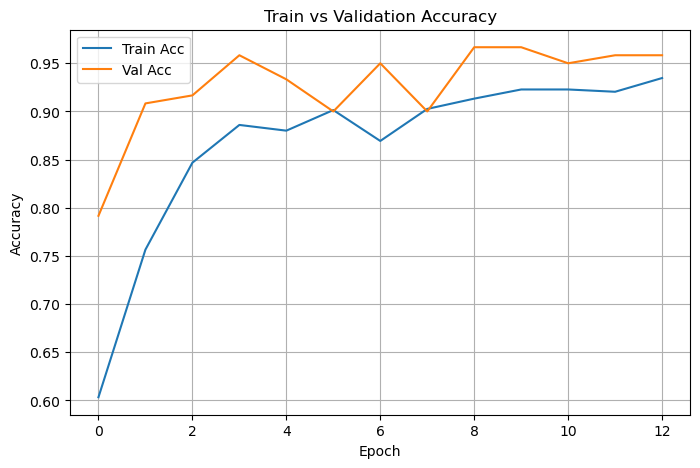

In [9]:
import matplotlib.pyplot as plt

# accuracies
plt.figure(figsize=(8,5))
plt.plot(train_history, label="Train Acc")
plt.plot(val_history, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


## AutoEncoder

In [10]:
from torch.utils.data import Subset, DataLoader
# Para entrenar el AE usaremos la clase no smile
# Como sólo trabajamos con una clase durante el training, no tiene sentido obtener accuracy durante train.
# Una vez entrenado y establecido el threshold podemos obtener accuracies. 

# Lista de índices de la clase normal (no smile==0)
normal_indices = []
for idx_in_subset, original_idx in enumerate(train_dataset.indices):
    _, label = full_dataset[original_idx]
    if label.item() == 0:    # 0 = no-smile, clase normal
        normal_indices.append(original_idx)

# Dataset de la clase normal 
normal_train_dataset = Subset(full_dataset, normal_indices)

# AE loader
normal_train_loader = DataLoader(
    normal_train_dataset,
    batch_size=32,
    shuffle=True
)

print("Cantidad de imágenes normales para AE:", len(normal_train_dataset))

Cantidad de imágenes normales para AE: 422


In [11]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder: reduce tamaño
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),   # 64 a 32
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 32 a 16
            nn.ReLU()
        )

        # Decoder: expande tamaño 
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), # 16 a 32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),  # 32 a 64 (original resolution )
            nn.Sigmoid()   # salida en [0,1]
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

In [ ]:
def train_autoencoder(autoencoder,
                    normal_train_loader, 
                    train_loader_full, 
                    val_loader_full, 
                    test_loader, 
                    epochs=20,
                    lr=0.01,
    threshold_percentile=95
):
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    autoencoder = autoencoder.to(device)

    optimizer = optim.SGD(autoencoder.parameters(), lr=lr)
    criterion = nn.MSELoss() #distancia entre imagen og y recon 

    train_losses = []
    
    # training time 
    start_time = time.time()

    for epoch in range(epochs):
        # TRAIN
        autoencoder.train()
        train_loss = 0.0

        for data, labels in normal_train_loader:
            data = data.to(device)

            optimizer.zero_grad() 
            recon = autoencoder(data)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_loss = train_loss / len(normal_train_loader)
        train_losses.append(avg_loss)

        print(f"Epoch {epoch+1}/{epochs} - Recon Loss: {avg_loss:.4f}")

    training_time = time.time() - start_time # end training time

    # EVAL
    autoencoder.eval()
    normal_errors = [] # dist del error normal 

    with torch.no_grad():
        for data, labels in normal_train_loader:
            data = data.to(device)
            recon = autoencoder(data) #outputs 
            mse = ((recon - data)**2).view(data.size(0), -1).mean(dim=1) # mse promedio (por pixeles) por imagen
            #: tensor([mse_img1, mse_img2, mse_img3, ..., mse_img32])
            normal_errors.extend(mse.cpu().numpy()) # guardamos 

    normal_errors = np.array(normal_errors)
    mu = normal_errors.mean()
    sigma = normal_errors.std()

    # umbral: una imagen es anomalía si su error es mucho mayor al de las normales.
    # Regla simple de outliers: media + 2 std
    threshold = mu + 2 * sigma

    # Encoder -> Clasificador 
    def eval_accuracy(loader):
        y_true, y_pred = [], []
        with torch.no_grad():
            for data, labels in loader:
                data = data.to(device)
                labels = labels.numpy()

                recon = autoencoder(data)
                mse = ((recon - data)**2).view(data.size(0), -1).mean(dim=1).cpu().numpy()

                preds = (mse > threshold).astype(int) # TRUE == 1 (smile/anomalía)
                y_true.extend(labels)
                y_pred.extend(preds)

        return accuracy_score(y_true, y_pred)

    train_acc = eval_accuracy(train_loader_full)
    val_acc   = eval_accuracy(val_loader_full)
    test_acc  = eval_accuracy(test_loader)

    # parámetros y ops
    num_params = count_parameters(autoencoder)
    flops = count_operations(autoencoder, input_size=(1,3,64,64))

    # tiempo de inferencia
    sample, _ = next(iter(test_loader))  #tomamos batch representativo
    mean_inf, std_inf = count_time(autoencoder, sample, n_runs=100) 

    return {
        "train_accuracy": train_acc,
        "val_accuracy":   val_acc,
        "test_accuracy":  test_acc,
        "training_time_sec": training_time,
        "inference_time_mean_ms": float(mean_inf*1000),
        "inference_time_std_ms":  float(std_inf*1000),
        "num_parameters": num_params,
        "flops_per_forward": flops,
        "threshold": float(threshold)
    }

In [13]:
ae = ConvAutoencoder()

ae_metrics = train_autoencoder(
    autoencoder=ae,
    normal_train_loader=normal_train_loader,   # solo clase normal (ej.: label 0)
    train_loader_full=train_loader,            # train con labels 0/1
    val_loader_full=val_loader,
    test_loader=test_loader,
    epochs=20,
    lr=0.01
)

print("\nMétricas Autoencoder:")
for k, v in ae_metrics.items():
    print(f"{k}: {v}")

Epoch 1/20 - Recon Loss: 0.0410
Epoch 2/20 - Recon Loss: 0.0399
Epoch 3/20 - Recon Loss: 0.0398
Epoch 4/20 - Recon Loss: 0.0399
Epoch 5/20 - Recon Loss: 0.0398
Epoch 6/20 - Recon Loss: 0.0404
Epoch 7/20 - Recon Loss: 0.0396
Epoch 8/20 - Recon Loss: 0.0394
Epoch 9/20 - Recon Loss: 0.0393
Epoch 10/20 - Recon Loss: 0.0398
Epoch 11/20 - Recon Loss: 0.0397
Epoch 12/20 - Recon Loss: 0.0389
Epoch 13/20 - Recon Loss: 0.0388
Epoch 14/20 - Recon Loss: 0.0387
Epoch 15/20 - Recon Loss: 0.0385
Epoch 16/20 - Recon Loss: 0.0389
Epoch 17/20 - Recon Loss: 0.0386
Epoch 18/20 - Recon Loss: 0.0387
Epoch 19/20 - Recon Loss: 0.0386
Epoch 20/20 - Recon Loss: 0.0385

Métricas Autoencoder:
train_accuracy: 0.49643705463182897
val_accuracy: 0.5083333333333333
test_accuracy: 0.4854771784232365
training_time_sec: 9.15890097618103
inference_time_mean_ms: 7.431497573852539
inference_time_std_ms: 0.5593876155733025
num_parameters: 38723
flops_per_forward: 28016640.0
threshold: 0.06887306272983551


## SVM

In [14]:
def subset_to_numpy(subset, batch_size=64):
    """
    Convierte un Subset/Dataset de PyTorch en:
    X: imágenes aplanadas (num_muestras, num_features)
    y: etiquetas (num_muestras,)
    """
    loader = DataLoader(subset, batch_size=batch_size, shuffle=False)
    X_list, y_list = [], []

    for images, labels in loader:
        # images: (B, 3, 64, 64) -> (B, 3*64*64)
        X_list.append(images.view(images.size(0), -1).numpy())
        y_list.append(labels.numpy())

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return X, y

In [15]:
def train_svm(
    X_train, y_train,
    X_val,   y_val,
    X_test,  y_test,
    n_components=50,   # nº de componentes PCA
    C=0.1,             # regularización
    random_state=42
):
    # TRAIN
    start_time = time.time()  # training start time

    svm = make_pipeline(
        StandardScaler(),
        PCA(n_components=n_components, random_state=random_state), # Para reducir Overfitting 
        LinearSVC(C=C, random_state=random_state, max_iter=5000)
    )

    svm.fit(X_train, y_train)
    training_time = time.time() - start_time # trainig end time 

    # Calculamos accuracy
    y_train_pred = svm.predict(X_train)
    y_val_pred   = svm.predict(X_val)
    y_test_pred  = svm.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc   = accuracy_score(y_val,   y_val_pred)
    test_acc  = accuracy_score(y_test,  y_test_pred)

    # Tiempos de inferencia
    def count_time_np (model, X_sample, n_runs=100, warmup=10):
        '''Mide tiempo de inferencia para numpy arrays'''
        times = []
        for i in range(warmup):
            i = model.predict(X_sample)
        for i in range(n_runs):
            t0 = time.time()
            i = model.predict(X_sample)
            t1 = time.time()
            times.append(t1 - t0)
        times = np.array(times)
        return times.mean(), times.std()

    X_sample = X_test[:64]
    mean_inf, std_inf = count_time_np(svm, X_sample)

    # parámetros y flops en 0 
    num_params = 0
    flops_per_forward = 0

    metrics = {
        "train_accuracy": train_acc,
        "val_accuracy":   val_acc,
        "test_accuracy":  test_acc,
        "training_time_sec": training_time,
        "inference_time_mean_ms": float(mean_inf * 1000),
        "inference_time_std_ms":  float(std_inf * 1000),
        "num_parameters":  num_params,
        "flops_per_forward": flops_per_forward,
    }

    return svm, metrics

In [16]:
# Convertir datasets a matrices numpy
X_train, y_train = subset_to_numpy(train_dataset)
X_val,   y_val   = subset_to_numpy(val_dataset)
X_test,  y_test  = subset_to_numpy(test_dataset)

# Entrenar SVM y obtener métricas
svm_model, svm_metrics = train_svm(
    X_train, y_train,
    X_val,   y_val,
    X_test,  y_test,
    C=1.0
)

print("\nMétricas SVM:")
for k, v in svm_metrics.items():
    print(f"{k}: {v}")


Métricas SVM:
train_accuracy: 0.9156769596199525
val_accuracy: 0.8583333333333333
test_accuracy: 0.8713692946058091
training_time_sec: 0.1906588077545166
inference_time_mean_ms: 1.692979335784912
inference_time_std_ms: 0.13737561285554065
num_parameters: 0
flops_per_forward: 0
